In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats

data.csv includes lastest edition FIFA 2019 players attributes like Age, Nationality, Overall, Club,              
Wage, Preferred_Foot, Position, Height, Weight, ShortPassing, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Positioning, Penalties.  

Данные включают в себя последние издания FIFA 2019 игроков атрибуты, такие как Возраст, Национальность, Общий, Клуб, Заработная плата, Предпочтительная нога, Положение, Рост, Вес, Шортпассинг, Точность FK,Long Passing, Контроль мяча, Ускорение, Скорость спринта, Ловкость,Реакции, баланс, сила удара, прыжки, выносливость, сила,Длинные выстрелы, Позиционирование, Пенальти

In [2]:
master_data=pd.read_csv('data.csv')
master_data.head()
master_data.drop(columns = ['Unnamed: 0','Name','ID','WorkRate','BodyType','RealFace','LoanedFrom','Value','InternationalReputation','Joined','WeakFoot','GKDiving', 'GKHandling','GKKicking', 'GKPositioning','Aggression','Vision','Vision','Special', 'SkillMoves','Volleys', 'Dribbling', 'Curve','Interceptions', 'HeadingAccuracy','Crossing', 'Potential','Finishing', 'GKReflexes', 'ReleaseClause','ContractValidUntil','JerseyNumber','Flag','ClubLogo','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Photo','Composure', 'Marking', 'StandingTackle', 'SlidingTackle'], inplace=True)
master_data.columns.str.strip()
master_data.rename(columns = {'PreferredFoot':'Preferred_Foot'                              
                             }, inplace = True)
master_data.fillna(master_data.mean(), inplace=True)
# 

Подготовка данных, убираем NaN значения - заменяем на среднее значение, переводим единицы измерения к русским и обрабатываем категориальные признаки

In [3]:
master_data['Wage'] = master_data.Wage.str.replace('€','')
master_data['Wage'] = master_data.Wage.str.replace('K','000')
master_data['Wage'] = master_data.Wage.astype('int64')
master_data['Weight'] = master_data.Weight.str.replace('lbs','').astype('float64')
master_data['Height'] = master_data.Height.str.replace('\'','.').astype('float64')
master_data.fillna(0, inplace=True)
master_data['Preferred_Foot'] = master_data.Preferred_Foot.astype('category')
master_data['Nationality'] = master_data.Nationality.astype('category')
master_data['Club'] = master_data.Club.astype('category')
master_data['Position'] = master_data.Position.astype('category')
master_data['Weight'] = master_data.Weight*0.454
master_data['Height'] = master_data.Height*30

In [4]:
master_data.head().T

,0,1,2,3,4
Age,31,33,26,27,27
Nationality,Argentina,Portugal,Brazil,Spain,Belgium
Overall,94,94,92,91,91
Club,FCBarcelona,Juventus,ParisSaint-Germain,ManchesterUnited,ManchesterCity
Wage,565000,405000,290000,260000,355000
Preferred_Foot,Left,Right,Right,Right,Right
Position,RF,ST,LW,GK,RCM
Height,171,186,177,192,153.3
Weight,72.186,83.082,68.1,76.272,69.916
ShortPassing,90,81,84,50,92


Для данного массива проведем статистический анализ каждой переменной, вычислив ее выборочные числовые характеристики: среднее, дисперсию, моду, медиану, эксцесс, асимметрию, коэффициент вариации, размах.

In [6]:
cols = ['Mean', 'Mode', 'Median', 'Variance', 'Skew', 'Kurtosis', 'Range', 'Std', 'k variation']
temp= []
dt_stat = pd.DataFrame(columns=cols)
pre_dt = 0
for name, values in master_data.iteritems():
    if (master_data[name].dtype.name != 'category'):
#         temp.append(name)
        temp.append(statistics.mean(master_data[name]))
        temp.append(statistics.mode(master_data[name]))
        temp.append(statistics.median(master_data[name]))
        temp.append(statistics.variance(master_data[name]))
        temp.append(stats.skew(master_data[name]))
        temp.append(stats.kurtosis(master_data[name]))
        temp.append(np.max(master_data[name])-np.min(master_data[name]))
        temp.append(np.std(master_data[name]))
        temp.append(np.std(master_data[name])/statistics.mean(master_data[name])*100)  
        dt_stat.loc[name] = temp
        temp=[]
        pre_dt = pre_dt+1
print(dt_stat)
        

                     Mean     Mode   Median      Variance      Skew  \
Age             25.122206    21.00    25.00  2.180836e+01  0.391732   
Overall         66.238699    66.00    66.00  4.773331e+01  0.067179   
Wage          9731.312133  1000.00  3000.00  4.839688e+08  7.905368   
Height         173.462498   180.00   177.00  2.598840e+02 -3.541539   
Weight          75.155864    74.91    74.91  6.491681e+01 -1.936397   
ShortPassing    58.686712    64.00    62.00  2.155055e+02 -1.101678   
FKAccuracy      42.863153    42.00    41.00  3.047017e+02  0.102244   
LongPassing     52.711933    62.00    56.00  2.343242e+02 -0.596378   
BallControl     58.369459    65.00    63.00  2.777084e+02 -1.269433   
Acceleration    64.614076    69.00    67.00  2.222511e+02 -0.816311   
SprintSpeed     64.726967    68.00    67.00  2.140553e+02 -0.829612   
Agility         63.503607    68.00    66.00  2.174614e+02 -0.600158   
Reactions       61.836610    65.00    62.00  8.097442e+01 -0.114268   
Balanc

Визуализация разброса каждого фактора

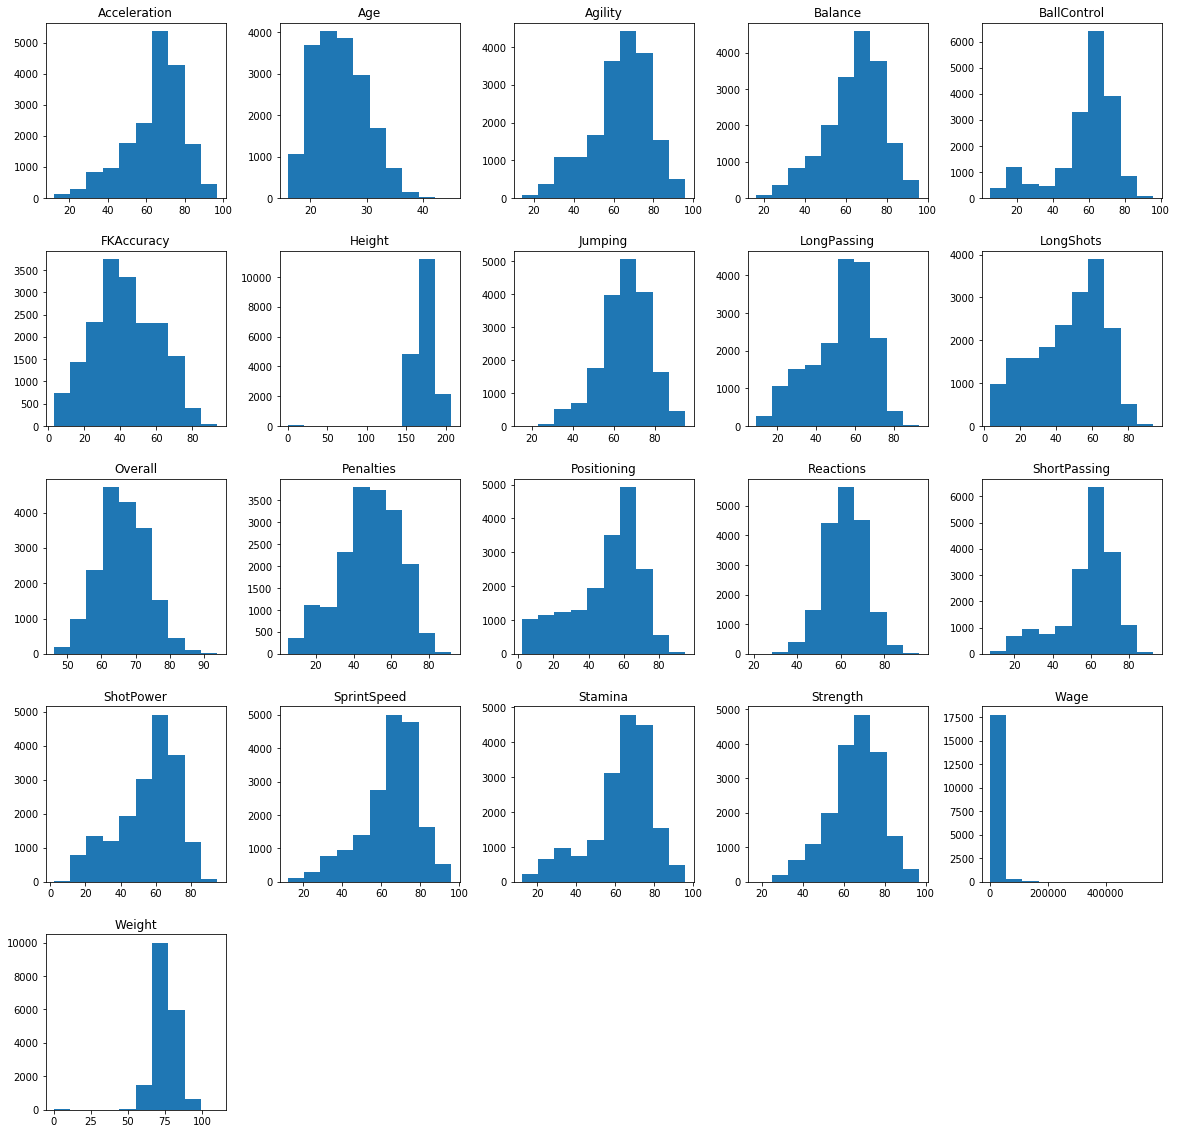

In [20]:
histohrams = master_data.hist(grid=False, figsize=(20, 20))

Построим корреляционную матрицу для вычисления тесноты связей между зависимой переменной и каждым фактором

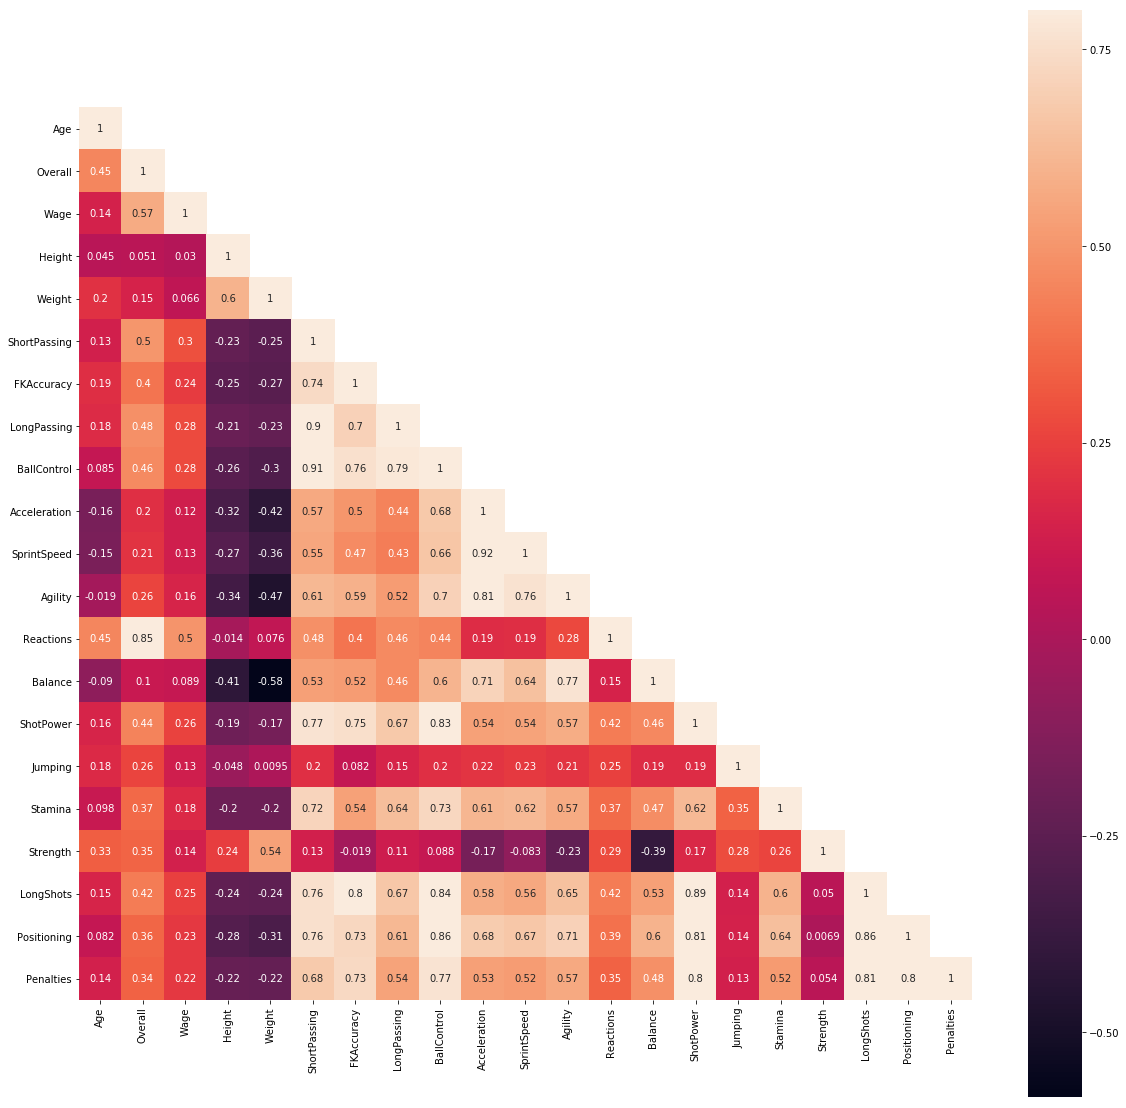

In [8]:
corr = master_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
sn.heatmap(corr, mask=mask, vmax=.8, square=True, annot = True)

Построим уравнение множественной линейной регрессии, включив в модель все имеющиеся факторы.

Набор обучающих данных будет использоваться для обучения нашей линейной модели. Тестовый набор выбирается случайным образом данных будет использоваться для проверки модели. Все данные из тестового набора данных будут новыми для модели, и мы сможем проверить, насколько точны прогнозы модели.

In [7]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position'], axis=1)
Y = master_data['Overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

Коэффициенты регрессии

In [8]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, Y_train)
cdf = pd.DataFrame(lin_reg.coef_,X.columns, columns=['Coefficients'])
print(cdf)
print("Independent term in the model "+ str(lin_reg.intercept_))

              Coefficients
Age               0.155250
Wage              0.000059
Height            0.012939
Weight            0.051542
ShortPassing      0.038836
FKAccuracy        0.002352
LongPassing       0.010751
BallControl       0.059260
Acceleration      0.024319
SprintSpeed       0.022393
Agility           0.028179
Reactions         0.471765
Balance          -0.042807
ShotPower         0.016363
Jumping           0.014610
Stamina          -0.026617
Strength          0.022573
LongShots         0.015371
Positioning      -0.061179
Penalties        -0.015665
Independent term in the model 19.408636895656386


Сравниваем предсказанное с тестом

In [9]:
Y_pred = lin_reg.predict(X_test)
# print('Prediction:', len(Y_pred))
# средне квадратическая ошибка
mse = mean_squared_error(Y_test, Y_pred)
print('mean_squared_error : ',mse)

mean_squared_error :  9.750295262049308


In [12]:
#R^2 (coefficient of determination) regression score function.
r2 = r2_score(Y_test, Y_pred)
print('r2 score: ',r2)
r2_adj = 1-((1-r2*r2)*(Y_pred.size-1)/(Y_pred.size-1-len(X_test.columns)))
print('r2_adj:', r2_adj)

r2 score:  0.792460418334445
r2_adj: 0.6269689856117302


In [21]:
alfa = 0.05
n = Y_pred.size-1-len(X_test.columns)
t = stats.t(n)
tcr = t.ppf(1-alfa/2)
F = (r2/(1-r2))*((Y_pred.size-len(X_test.columns)-1)/len(X_test.columns))
print("F :", F )
print ("t-stat_cr ", tcr)
print ("queue_mean", np.mean(Y_pred))
print ("queue_di", tcr*np.std(Y_pred)/np.sqrt(Y_pred.size))

F : 1386.445783440611
t-stat_cr  1.9602907071984967
queue_mean 66.12633356734565
queue_di 0.14006188096485025


МНК

In [25]:
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
# print(est2.summary())

In [24]:
abs(est2.tvalues) > tcr

const            True
Age              True
Wage             True
Height           True
Weight           True
ShortPassing     True
FKAccuracy      False
LongPassing      True
BallControl      True
Acceleration     True
SprintSpeed      True
Agility          True
Reactions        True
Balance          True
ShotPower        True
Jumping          True
Stamina          True
Strength         True
LongShots        True
Positioning      True
Penalties        True
dtype: bool

Незначимы: FKAccuracy

In [15]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           369.724943
Age               1.591596
Wage              1.382146
Height            1.594128
Weight            2.481010
ShortPassing     12.091204
FKAccuracy        3.767334
LongPassing       6.148667
BallControl      11.863054
Acceleration      8.847738
SprintSpeed       7.362059
Agility           4.542620
Reactions         2.084897
Balance           3.523486
ShotPower         6.367901
Jumping           1.360530
Stamina           3.018958
Strength          2.612934
LongShots         7.777637
Positioning       6.509226
Penalties         4.000597
dtype: float64

Получается так. Часто используют границу 5 или 10, если показатель VIF больше данного значения - есть линейная зависимость от остальных переменных

Если VIF (Variance Inflation Factor) возле каждой независимой переменной меньше 10 — значит, эффекта мультиколлинеарности не наблюдается и регрессионная модель приемлема для дальнейшей интерпретации. Чем выше показатель VIF, тем более связаны между собой переменные

Пересторим модель без учета факторов ShortPassing и BallControl

In [29]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position',
                      'ShortPassing',
                      'BallControl',
                     ], axis=1)
Y = master_data['Overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
# print(est2.summary())
X3=[]
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           335.160721
Age               1.550336
Wage              1.371225
Height            1.678802
Weight            2.551485
FKAccuracy        3.839102
LongPassing       2.851905
Acceleration      8.845744
SprintSpeed       7.378549
Agility           4.492948
Reactions         2.070098
Balance           3.528675
ShotPower         6.033293
Jumping           1.362880
Stamina           2.979327
Strength          2.553119
LongShots         7.858000
Positioning       5.823084
Penalties         3.788233
dtype: float64

методом включения факторов в модель на основе прироста скорректированного коэффициента детерминации построим уравнение множественной регрессии

In [38]:
for i in X_train.columns:
    col = [i]
    XX = X_train[col]
    X2 = sm.add_constant(XX)
    est = sm.OLS(Y_train, X2)
    est2 = est.fit()
    print('factor :',i,'r2_adj:',est2.rsquared_adj)

factor : Age r2_adj: 0.21166508291747665
factor : Wage r2_adj: 0.33045191257464557
factor : Height r2_adj: 0.0032450850337587545
factor : Weight r2_adj: 0.025695393913204523
factor : FKAccuracy r2_adj: 0.1552143622028863
factor : LongPassing r2_adj: 0.23270092187403668
factor : Acceleration r2_adj: 0.03558096157046109
factor : SprintSpeed r2_adj: 0.04081247545647526
factor : Agility r2_adj: 0.06488496777312636
factor : Reactions r2_adj: 0.722806811955127
factor : Balance r2_adj: 0.009262760924258706
factor : ShotPower r2_adj: 0.19491179325010055
factor : Jumping r2_adj: 0.07052674010154225
factor : Stamina r2_adj: 0.12899114110533227
factor : Strength r2_adj: 0.12719348613164339
factor : LongShots r2_adj: 0.17545326267581318
factor : Positioning r2_adj: 0.12445738381955374
factor : Penalties r2_adj: 0.1141734480748211


Reactions r2_adj: 0.722806811955127 - max r2_adj

In [41]:
col=['Reactions']
for i in X_train.columns:
    if i!='Reactions':
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions']

factors ['Reactions', 'Age'] r2_adj: 0.7292429456089107
factors ['Reactions', 'Wage'] r2_adj: 0.7532802394031949
factors ['Reactions', 'Height'] r2_adj: 0.7271430334103222
factors ['Reactions', 'Weight'] r2_adj: 0.7316180060764866
factors ['Reactions', 'FKAccuracy'] r2_adj: 0.7263173327518396
factors ['Reactions', 'LongPassing'] r2_adj: 0.7326971537290965
factors ['Reactions', 'Acceleration'] r2_adj: 0.7235723107797799
factors ['Reactions', 'SprintSpeed'] r2_adj: 0.7244306291469229
factors ['Reactions', 'Agility'] r2_adj: 0.7233284281506769
factors ['Reactions', 'Balance'] r2_adj: 0.7236598766682434
factors ['Reactions', 'ShotPower'] r2_adj: 0.7312637865254772
factors ['Reactions', 'Jumping'] r2_adj: 0.7251591736479317
factors ['Reactions', 'Stamina'] r2_adj: 0.7251930052299241
factors ['Reactions', 'Strength'] r2_adj: 0.736120154567701
factors ['Reactions', 'LongShots'] r2_adj: 0.7269483951276514
factors ['Reactions', 'Positioning'] r2_adj: 0.7234664483546724
factors ['Reactions', 'Pe

factors ['Reactions', 'Wage'] r2_adj: 0.7532802394031949 - max 

In [45]:
col=['Reactions','Wage']
for i in X_train.columns:
    if ((i!='Reactions')or(i!='Wage')):
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions','Wage']

factors ['Reactions', 'Wage', 'Age'] r2_adj: 0.76307599334036
factors ['Reactions', 'Wage', 'Wage'] r2_adj: 0.7532802394031949
factors ['Reactions', 'Wage', 'Height'] r2_adj: 0.7566391403627934
factors ['Reactions', 'Wage', 'Weight'] r2_adj: 0.7609261796280425
factors ['Reactions', 'Wage', 'FKAccuracy'] r2_adj: 0.755939273031358
factors ['Reactions', 'Wage', 'LongPassing'] r2_adj: 0.7613875964869725
factors ['Reactions', 'Wage', 'Acceleration'] r2_adj: 0.7538238144769969
factors ['Reactions', 'Wage', 'SprintSpeed'] r2_adj: 0.7544829059746255
factors ['Reactions', 'Wage', 'Agility'] r2_adj: 0.7537195356291186
factors ['Reactions', 'Wage', 'Reactions'] r2_adj: 0.7532802394031948
factors ['Reactions', 'Wage', 'Balance'] r2_adj: 0.7542415003182646
factors ['Reactions', 'Wage', 'ShotPower'] r2_adj: 0.7598799196849133
factors ['Reactions', 'Wage', 'Jumping'] r2_adj: 0.755646583310331
factors ['Reactions', 'Wage', 'Stamina'] r2_adj: 0.7559615358339616
factors ['Reactions', 'Wage', 'Strength']

factors ['Reactions', 'Wage', 'Strength'] r2_adj: 0.7667135825917197 - max

In [46]:
col=['Reactions','Wage','Strength']
for i in X_train.columns:
    if ((i!='Reactions')or(i!='Wage')or(i!='Strength')):
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions','Wage','Strength']

factors ['Reactions', 'Wage', 'Strength', 'Age'] r2_adj: 0.7721649398838889
factors ['Reactions', 'Wage', 'Strength', 'Wage'] r2_adj: 0.7667135825917197
factors ['Reactions', 'Wage', 'Strength', 'Height'] r2_adj: 0.7676270600714423
factors ['Reactions', 'Wage', 'Strength', 'Weight'] r2_adj: 0.7676337615264296
factors ['Reactions', 'Wage', 'Strength', 'FKAccuracy'] r2_adj: 0.771494797951097
factors ['Reactions', 'Wage', 'Strength', 'LongPassing'] r2_adj: 0.7750764078265202
factors ['Reactions', 'Wage', 'Strength', 'Acceleration'] r2_adj: 0.7692615577775748
factors ['Reactions', 'Wage', 'Strength', 'SprintSpeed'] r2_adj: 0.76929390531211
factors ['Reactions', 'Wage', 'Strength', 'Agility'] r2_adj: 0.7708131123671274
factors ['Reactions', 'Wage', 'Strength', 'Reactions'] r2_adj: 0.7667135825917197
factors ['Reactions', 'Wage', 'Strength', 'Balance'] r2_adj: 0.7672336063300781
factors ['Reactions', 'Wage', 'Strength', 'ShotPower'] r2_adj: 0.772196177073694
factors ['Reactions', 'Wage', 'St

In [55]:
col=['Reactions','Wage','Strength']
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 1.197e+04
Date:                Sun, 21 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:56:22   Log-Likelihood:                -28755.
No. Observations:               10924   AIC:                         5.752e+04
Df Residuals:                   10920   BIC:                         5.755e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4100      0.269    101.779      0.0

In [56]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const        69.962826
Reactions     1.422522
Wage          1.329985
Strength      1.091558
dtype: float64

In [57]:
np.linalg.cond(est2.model.exog)

204709.0673766557

In [58]:
np.abs(est2.params/np.std(Y_train)*np.std(X_train[col])).sort_values(ascending = False)

Reactions    0.714602
Wage         0.201767
Strength     0.121177
const             NaN
dtype: float64

In [59]:
np.abs(est2.params/np.mean(Y_train)*np.mean(X_train[col])).sort_values(ascending = False)

Reactions    0.510639
Strength     0.066184
Wage         0.009326
const             NaN
dtype: float64

In [69]:
print(len(Y_train))
print(len(X2))
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X2, Y_train)
print(lin_reg.predict(X2))

10924
10924
[58.11333306 68.448363   63.21195503 ... 58.52617866 62.46671238
 67.09859928]


In [70]:
np.mean(lin_reg.predict(X2) - Y_train)

-7.40788284288885e-15

Так как значение получилось близко к нулю, то считается, что модель не содержит систематической ошибки и адекватна по критерию нулевого среднего

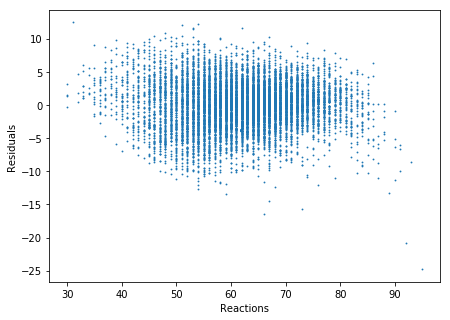

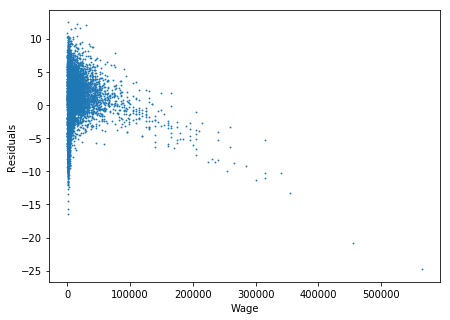

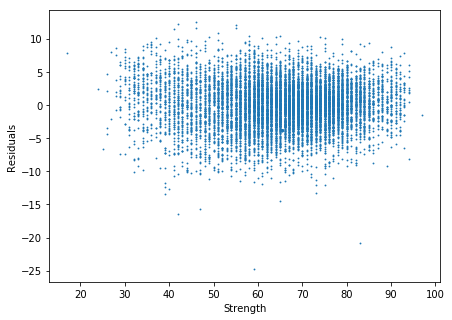

In [71]:
for i, j in enumerate(col):
    plt.figure(figsize=(7,5))
    plt.scatter(X_train[j], est2.resid, s=0.7)
    plt.xlabel(j)
    plt.ylabel('Residuals')

plt.show()


In [72]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(est2.resid, est2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 919.3664531595639),
 ('p-value', 5.575287621499861e-199),
 ('f-value', 334.49439940333116),
 ('f p-value', 8.289067437203595e-208)]

f_pvalue = 0, поэтому H0(гомоскедастичность) отклоняется.

In [73]:
durbin_watson(est2.resid)

2.0193882636776874

~2, следовательно, нет автокорреляциии